In [1]:
import sys
sys.path.append('..')  # allow this notebook to find equal-level directories
%pylab inline
from importing_modules import *
# pyomo.environ as oe, seaborn as sns, plotly.plotly as py, plotly.graph_objs as go
# from util.gjh_wrapper import gjh_solve, make_df, from vis import acres_bars, zL_bars

# Load the County-version of the model.
# from util.subproblem_model_costobjective_county import CostObj

Populating the interactive namespace from numpy and matplotlib


## Create problem instance

In [2]:
# Load data for each set, parameter, etc. to define a problem instance
objwrapper = CostObj()
# lrsegs = ['N42071SL2_2410_2700']
lrsegs = ['N51133RL0_6450_0000']
# counties = ['Anne Arundel, MD']
# counties = ['Northumberland, VA']
data = objwrapper.load_data(savedata2file=False, lrsegs_list=lrsegs)
# data = objwrapper.load_data(savedata2file=False, county_list=counties)

# ---- Set the tau target load ----
for k in data.tau:
    data.tau[k] = 12
    taustr = str(round(data.tau[k], 1))
    

In [3]:
# Create concrete problem instance using the separately defined optimization model
mdl = objwrapper.create_concrete(data=data)
# Print the target load reduction values
# for l in mdl.LRSEGS:
#     for p in mdl.PLTNTS:
#         print('%s: %d' % (mdl.tau[l,p], mdl.tau[l,p].value))

# Retain only the Nitrogen load constraints, and deactivate the others
for l in mdl.LRSEGS:
    print('%s: %d' % (mdl.tau[l,'N'], mdl.tau[l,'N'].value))
    mdl.TargetPercentReduction[l,'P'].deactivate()
    mdl.TargetPercentReduction[l,'S'].deactivate()

# ---- Solver name ----
localsolver = True
solvername = 'ipopt'
# solvername = 'minos'

tau[N51133PL0_6272_0000,P]: 12
tau[N51133RL0_6501_0000,P]: 12
tau[N51133PL0_6271_0000,P]: 12
tau[N51133PL0_6270_0000,P]: 12
tau[N51133RL0_6450_0000,P]: 12
tau[N51133PL0_6140_0000,P]: 12
tau[N51133RL0_6530_0000,P]: 12


In [ ]:
tol = 1e-2
nzvarnames = []
nzvarvalus = []
i=0
for k in mdl.x.keys():
#     print(k)
    if not not mdl.x[k].value:
#         print(mdl.x[k].value)
        if abs(mdl.x[k].value) > tol:
            nzvarnames.append(mdl.x[k].getname())
            nzvarvalus.append(mdl.x[k].value)
    i+=1
#     if i > 100:
#         break
print(i)

In [ ]:
# for index in mdl.x:
#     mdl.x[index].value=0
#             x_value = oe.value(v[index])

# reinitialize the variables
for k in mdl.x:
#         mdl.x[k] = float(random.randrange(0, 600001))/100
    mdl.x[k] = round(random.uniform(0, 6000), 2)

In [ ]:
# mdl.x.pprint()

## Solve problem instance

In [4]:
looptimestamp = datetime.now().strftime('%Y-%m-%d_%H%M%S')

myobj = SolveAndParse(instance=mdl, data=data, localsolver=localsolver, solvername=solvername)
# set filepath for saving information about all of the solver iterates
output_file_name=os.path.join(projectpath, ''.join(['output/single_CostObj_', looptimestamp, '.iters']))
IpoptParser().modify_ipopt_options(optionsfilepath='ipopt.opt', newoutputfilepath=output_file_name)

# file_print_levels:
#   4 for just # of iterations, and final objective, infeas,etc. values
#   6 for summary information about all iterations, but not variable values
#   8 for variable values at all iterations
#   10 for all iterations
IpoptParser().modify_ipopt_options(optionsfilepath='ipopt.opt', newfileprintlevel='8')

merged_df = myobj.solve(get_suffixes=False)
print('\nObjective is: %d' % oe.value(mdl.Total_Cost))

Solver log file: 'logfile_loadobjective.log'
Solver solution file: '/var/folders/qx/2v7d4gls4d10zzr_ptplrx240000gr/T/tmpdkz58c_x.pyomo.sol'
Solver problem files: ('/var/folders/qx/2v7d4gls4d10zzr_ptplrx240000gr/T/tmpdkz58c_x.pyomo.nl',)
Ipopt 3.12.8: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.8, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:    17203
Number of nonzeros in Lagrangian Hessian.............:    36628

Total number of variable

  74  4.8421156e+05 0.00e+00 4.35e+00  -8.6 7.08e-03    -  6.32e-01 7.94e-01f  1
  75  4.8421156e+05 0.00e+00 2.39e+00  -8.6 5.26e-03    -  4.50e-01 1.00e+00f  1
  76  4.8421156e+05 0.00e+00 2.84e-14  -8.6 5.73e-05    -  1.00e+00 1.00e+00f  1

Number of Iterations....: 76

                                   (scaled)                 (unscaled)
Objective...............:   3.4065771614243090e+03    4.8421155904028361e+05
Dual infeasibility......:   2.8421709430404007e-14    4.0398674627795115e-12
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   4.8011799870026282e-09    6.8244068358855100e-07
Overall NLP error.......:   4.8011799870026282e-09    6.8244068358855100e-07


Number of objective function evaluations             = 77
Number of objective gradient evaluations             = 77
Number of equality constraint evaluations            = 0
Number of inequality constraint evaluations          = 77
Number of equality constraint Jacobia

In [6]:
# asdkjhg
from util.solution_wrangler import get_nonzero_var_names_and_values
nzvnames, nzvvalues = get_nonzero_var_names_and_values(mdl)
print(len(nzvnames))
nzvnames[1]

106


'x[UrbanNMPlanHR,N51133PL0_6272_0000,mcn]'

In [ ]:
# for ii in mdl.x.iteritems():
#     print(ii)

In [7]:
tol = 1e-2
nzvarnames = []
nzvarvalus = []
i=0
for k in mdl.x.keys():
#     print(k)
    if not not mdl.x[k].value:
#         print(mdl.x[k].value)
        if abs(mdl.x[k].value) > tol:
            nzvarnames.append(mdl.x[k].getname())
            nzvarvalus.append(mdl.x[k].value)
    i+=1
#     if i > 100:
#         break
print(i)

53382


In [9]:
print(output_file_name)
dict_of_iterates = IpoptParser().parse_output_file(output_file_name)
iter_data_dfs, summ_df = dict_of_iterates
# dict_of_iterates.keys()

/Users/Danny/Desktop/CATEGORIES/CAREER_MANAGEMENT/CRC_ResearchScientist_Optimization/Optimization_Tool/2_ExperimentFolder/ampl/OptEfficiencySubProblem/output/single_CostObj_2018-09-04_133627.iters
['0', '1.1443348e+05', '1.20e+01', '6.46e+01', '-1.0', '0.00e+00', '-', '0.00e+00', '0.00e+00', '0']


In [10]:
iter_data_dfs = dict_of_iterates[0]
summ_df = dict_of_iterates[1]

In [11]:
dict_of_iterates = iter_data_dfs
len(dict_of_iterates)


77

In [25]:
varvals = {}
varvals[0] = []
for ii in dict_of_iterates.keys():
    df = dict_of_iterates[ii]
#     display(df.head(5))
    val = float(df.loc[(df.outputname=='curr_x') &
                       (df.varname=='x') & 
                       (df.index.get_level_values('varindex')=='[ConPlan,N51133PL0_6140_0000,pas]')]['value'][0])
#     print(val)
    varvals[0].append(val)

varvals[1] = []
for ii in dict_of_iterates.keys():
    df = dict_of_iterates[ii]
    varvals[1].append(float(df.loc[(df.outputname=='curr_x') &
                                   (df.varname=='x') & 
                                   (df.index.get_level_values('varindex')=='[UrbanNMPlanHR,N51133PL0_6140_0000,ntg]')]['value'][0]))

Text(0,0.5,'varvals[1]')

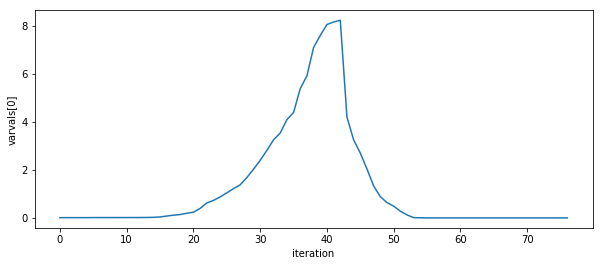

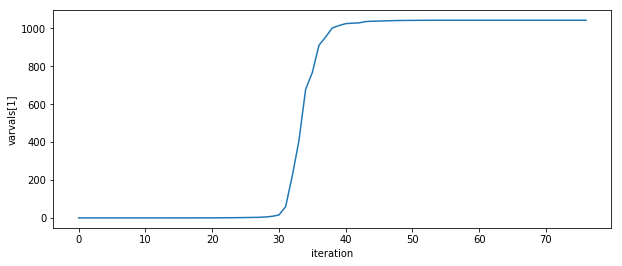

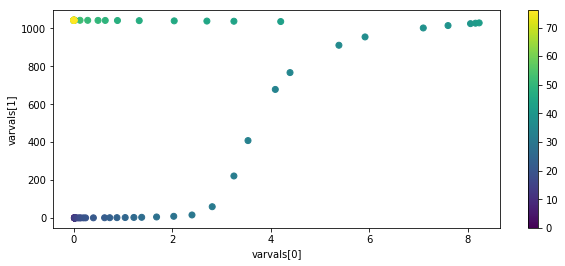

In [14]:
# Make Figure

fig = plt.figure(figsize=(10, 4))
rects = plt.plot(range(len(varvals[0])), varvals[0])
ax = plt.gca()
plt.ylabel('varvals[0]')
plt.xlabel('iteration')

fig = plt.figure(figsize=(10, 4))
rects = plt.plot(range(len(varvals[1])), varvals[1])
ax = plt.gca()
plt.ylabel('varvals[1]')
plt.xlabel('iteration')

fig = plt.figure(figsize=(10, 4))
rects = plt.scatter(varvals[0], varvals[1], c=range(len(varvals[1])))
ax = plt.gca()
plt.colorbar()
plt.xlabel('varvals[0]')
plt.ylabel('varvals[1]')

## Visualize

In [ ]:
merged_df.tail(50)

In [20]:
for l in mdl.LRSEGS:
    for p in mdl.PLTNTS:
        print('%s: %d' % (mdl.TargetPercentReduction[l,p], oe.value(mdl.TargetPercentReduction[l,p].body)))
#         print('%s: %d' % (mdl.TargetPercentReduction[l,p], mdl.TargetPercentReduction[l,p].value))

TargetPercentReduction[N51133PL0_6272_0000,S]: 58
TargetPercentReduction[N51133PL0_6272_0000,P]: 5
TargetPercentReduction[N51133PL0_6272_0000,N]: 11
TargetPercentReduction[N51133RL0_6501_0000,S]: 75
TargetPercentReduction[N51133RL0_6501_0000,P]: 19
TargetPercentReduction[N51133RL0_6501_0000,N]: 11
TargetPercentReduction[N51133PL0_6271_0000,S]: 58
TargetPercentReduction[N51133PL0_6271_0000,P]: 6
TargetPercentReduction[N51133PL0_6271_0000,N]: 11
TargetPercentReduction[N51133PL0_6270_0000,S]: 65
TargetPercentReduction[N51133PL0_6270_0000,P]: 4
TargetPercentReduction[N51133PL0_6270_0000,N]: 11
TargetPercentReduction[N51133RL0_6450_0000,S]: 44
TargetPercentReduction[N51133RL0_6450_0000,P]: 2
TargetPercentReduction[N51133RL0_6450_0000,N]: 11
TargetPercentReduction[N51133PL0_6140_0000,S]: 65
TargetPercentReduction[N51133PL0_6140_0000,P]: 11
TargetPercentReduction[N51133PL0_6140_0000,N]: 11
TargetPercentReduction[N51133RL0_6530_0000,S]: 55
TargetPercentReduction[N51133RL0_6530_0000,P]: 15
Targ

In [21]:
from datetime import datetime
# ---- Make zL Figure ----
filenamestr = ''.join(['output/costobj_zL_tau', taustr, '_', solvername, '_',
                       datetime.now().strftime('%Y-%m-%d_%H%M%S'),
                       '.png'])
savefilepathandname = os.path.join(projectpath, filenamestr)

zL_bars(df=merged_df, instance=mdl,
        savefig=True, savefilepathandname=savefilepathandname)

KeyError: 'zL'

<Figure size 720x288 with 0 Axes>

In [23]:
merged_df

,acres,bmpshortname,landriversegment,loadsource,totalannualizedcostperunit,totalinstancecost
0,9.367639,InfiltWithSV,N51133RL0_6530_0000,nir,1248.94,11699.618892
1,1.698977,UrbanNMPlanHR,N51133PL0_6272_0000,mcn,0.00,0.000000
2,150.921754,UrbanNMPlanHR,N51133PL0_6272_0000,ntg,0.00,0.000000
3,105.246628,UrbanNMPlanHR,N51133PL0_6272_0000,nch,0.00,0.000000
4,0.393142,UrbanNMPlanHR,N51133RL0_6501_0000,mcn,0.00,0.000000
5,43.999588,UrbanNMPlanHR,N51133RL0_6501_0000,ntg,0.00,0.000000
6,10.139029,UrbanNMPlanHR,N51133RL0_6501_0000,nch,0.00,0.000000
7,8.947154,UrbanNMPlanHR,N51133PL0_6271_0000,mcn,0.00,0.000000
8,818.382393,UrbanNMPlanHR,N51133PL0_6271_0000,ntg,0.00,0.000000
9,555.053289,UrbanNMPlanHR,N51133PL0_6271_0000,nch,0.00,0.000000


In [24]:
merged_df.sort_values(by='acres').shape

(106, 6)

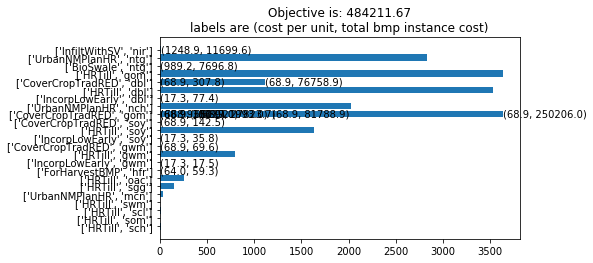

In [22]:
# ---- Acres Figure ----
sorteddf_byacres = merged_df.sort_values(by='acres')

filenamestr = ''.join(['output/costobj_x_tau', taustr, '_', solvername, '_',
                       datetime.now().strftime('%Y-%m-%d_%H%M%S'), '.png'])
savefilepathandname = os.path.join(projectpath, filenamestr)

objstr = ''.join(['Objective is: ', str(round(mdl.Total_Cost(), 2))])
titlestr = '\n'.join([objstr, 'labels are (cost per unit, total bmp instance cost)'])

acres_bars(df=sorteddf_byacres, instance=mdl, titlestr=titlestr,
           savefig=True, savefilepathandname=savefilepathandname)

## Gradient, Jacobian, Hessian

In [ ]:
gjh_filename, g = gjh_solve(instance=mdl,
                            keepfiles=True,
                            amplenv=ampl,
                            basegjhpath=os.getcwd())

g_df = make_df(instance=mdl, filterbydf=merged_df, g=g)

g_df = sorteddf_byacres.merge(g_df, how='left',
                              on=['bmpshortname', 'landriversegment', 'loadsource'],
                              sort=False)

In [ ]:
# ---- Make gradient Figure ----
# g_df_filtered = g_df.loc[abs(g_df['g'])>0.001,:].copy()
g_df_filtered = g_df
# sorteddf = g_df_filtered.sort_values(by='g')
# sorteddf_byacres

# sorteddf_byacres
# g_df = g_df.merge(sorteddf_byacres, how='right',
#                on=['bmpshortname', 'landriversegment', 'loadsource'])

keystrs = [str([x, y]) for x, y in zip(g_df_filtered['bmpshortname'], g_df_filtered['loadsource'])]
# Make Figure
fig = plt.figure(figsize=(10, 4))
rects = plt.barh(y=keystrs, width=g_df_filtered['g'])
ax = plt.gca()

ax.set_position([0.3,0.1,0.5,0.8])


filenamestr = ''.join(['output/costobj_g_tau', taustr, '_', solvername, '_',
                       datetime.now().strftime('%Y-%m-%d_%H%M%S'),
                       '.png'])
plt.savefig(os.path.join(projectpath, filenamestr))

In [ ]:
# #Read number of variables and constraints
# nl_file = open(''.join([filecode, '.pyomo.nl']),'r')
# nl_lines = nl_file.readlines()
# num_variables = int(nl_lines[1].split(' ')[1])
# num_constraints = int(nl_lines[1].split(' ')[2])

In [ ]:
for v in mdl.component_objects(oe.Var, active=True):
    print ("Variable component object",v)
    i=0
    for index in v:
        try:
            x_value = oe.value(v[index])
            i+=1
            try:
                print (i,"   ", index, v[index].value, g[i])
            except:
                print (i,"   ", index, v[index].value)
        except:
            pass

In [ ]:
# #Read number of variables and constraints
# gjh_file = open(''.join([filecode, '.pyomo.gjh']),'r')
# gjh_lines = gjh_file.readlines()

In [ ]:
# print(gjh_lines[1])

In [ ]:
# num_variables = int(gjh_lines[1].split(' ')[1])
# num_constraints = int(gjh_lines[1].split(' ')[2])

In [ ]:
# #Read gjh output file
# gjh = oe.AbstractModel()
# # gjh.n_var = oe.Set(initialize=range(1,num_variables+1))
# # gjh.n_cons = oe.Set(initialize=range(1,num_constraints+1))
# # gjh.g = oe.Param(gjh.n_var, default=0)
# # gjh.J = oe.Param(gjh.n_cons, gjh.n_var, default=0)
# # gjh.H = oe.Param(gjh.n_var, gjh.n_var, default=0)
# # os.rename(''.join([filecode, '.pyomo.gjh']), ''.join([filecode, '.pyomo.gjh.dat']))
# gjh_ins = gjh.create_instance(''.join([filecode, '.pyomo.gjh.dat']))

# #Print
# for i in gjh_ins.n_var:
#     print(gjh_ins.g[i])